# Final Project- ECG Signals

## Importing:

In [39]:
pip install wfdb

In [ ]:
# Raz is the king
# wefsfsdf

In [70]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     --------------------- ------------------ 30.

In [415]:
pip install --upgrade tensorflow keras



  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/ca/48/643d21747d52fa380f572f76c493779fc5b4bd03605247209d2dd0a6d9a9/keras-3.0.2-py3-none-any.whl.metadata


In [416]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wfdb
import ast


from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization,
                                     Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
                           accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer, LabelEncoder
from sklearn.pipeline import Pipeline



## EDA

In [41]:
path= 'C:/Users/Tal-Shachar\Google Drive/Naya-DS/Final project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
data = pd.read_csv(path+'ptbxl_database.csv', index_col=0)
data.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  infarc

In [43]:
len(set(data.report))

9887

### Load signals data:

In [44]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# path = 'path/to/ptbxl/'
# path= 'C:/Users/Tal-Shachar\Google Drive/Naya-DS/Final project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [45]:
X_test.shape

(2198, 1000, 12)

In [186]:
X_train.shape

(19601, 1000, 12)

In [46]:
y_test.shape

(2198,)

### Looking at the various categories in y:

In [195]:
categories_list = y_train.astype(str).unique()
categories_list

array(["['NORM']", "['MI']", '[]', "['STTC']", "['HYP']", "['CD']",
       "['STTC', 'MI']", "['HYP', 'CD']", "['CD', 'MI']",
       "['STTC', 'CD']", "['HYP', 'MI']", "['STTC', 'HYP', 'MI']",
       "['STTC', 'HYP']", "['CD', 'STTC', 'MI']", "['NORM', 'CD']",
       "['CD', 'STTC', 'HYP', 'MI']", "['STTC', 'HYP', 'CD']",
       "['MI', 'CD']", "['NORM', 'STTC']", "['CD', 'HYP', 'MI']",
       "['NORM', 'STTC', 'CD']", "['NORM', 'HYP']", "['MI', 'HYP', 'CD']",
       "['MI', 'STTC', 'CD']", "['MI', 'STTC', 'HYP', 'CD']",
       "['MI', 'NORM', 'HYP', 'CD']"], dtype=object)

In [200]:
y_train.value_counts()

diagnostic_superclass
[NORM]                 8157
[MI]                   2276
[STTC]                 2158
[CD]                   1524
[CD, MI]               1149
[STTC, HYP]             708
[STTC, MI]              538
[HYP]                   479
[STTC, CD]              433
[]                      371
[NORM, CD]              362
[STTC, HYP, MI]         320
[HYP, CD]               273
[CD, STTC, MI]          200
[STTC, HYP, CD]         186
[HYP, MI]               166
[CD, STTC, HYP, MI]     138
[CD, HYP, MI]           106
[NORM, STTC]             24
[MI, CD]                 15
[MI, HYP, CD]             6
[NORM, STTC, CD]          5
[NORM, HYP]               2
[MI, STTC, CD]            2
[MI, STTC, HYP, CD]       2
[MI, NORM, HYP, CD]       1
Name: count, dtype: int64

In [196]:
len(categories_list)

26

In [86]:
y_test.astype(str).unique()

array(["['NORM']", "['MI']", "['CD']", "['STTC']",
       "['CD', 'STTC', 'HYP', 'MI']", "['NORM', 'CD']",
       "['STTC', 'HYP', 'MI']", "['STTC', 'HYP']",
       "['STTC', 'HYP', 'CD']", '[]', "['MI', 'CD']", "['STTC', 'CD']",
       "['STTC', 'MI']", "['CD', 'STTC', 'MI']", "['CD', 'MI']",
       "['HYP', 'MI']", "['HYP']", "['CD', 'HYP', 'MI']", "['HYP', 'CD']",
       "['NORM', 'HYP', 'CD']", "['NORM', 'STTC']",
       "['MI', 'STTC', 'CD']"], dtype=object)

In [201]:
y_test.value_counts()

diagnostic_superclass
[NORM]                 912
[MI]                   256
[STTC]                 242
[CD]                   184
[CD, MI]               129
[STTC, HYP]             73
[STTC, MI]              61
[HYP]                   56
[NORM, CD]              45
[STTC, HYP, MI]         41
[]                      40
[STTC, CD]              38
[HYP, CD]               27
[STTC, HYP, CD]         25
[CD, STTC, MI]          20
[HYP, MI]               17
[CD, STTC, HYP, MI]     16
[CD, HYP, MI]            5
[MI, CD]                 4
[NORM, STTC]             4
[NORM, HYP, CD]          2
[MI, STTC, CD]           1
Name: count, dtype: int64

In [87]:
len(y_test.astype(str).unique())

22

### Looking at one person ECG signal:

In [22]:
test= pd.DataFrame(X[0])
test

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.106,0.028,-0.078,-0.067,0.092,-0.025,0.012,-0.008,0.025,0.020,-0.025,0.026
996,0.090,0.021,-0.069,-0.055,0.079,-0.023,-0.014,-0.009,-0.023,-0.027,-0.036,-0.008
997,0.069,0.000,-0.069,-0.034,0.069,-0.035,-0.001,-0.026,0.000,0.024,-0.041,-0.058
998,0.086,0.004,-0.081,-0.044,0.083,-0.038,0.001,-0.001,-0.025,0.242,-0.046,-0.098


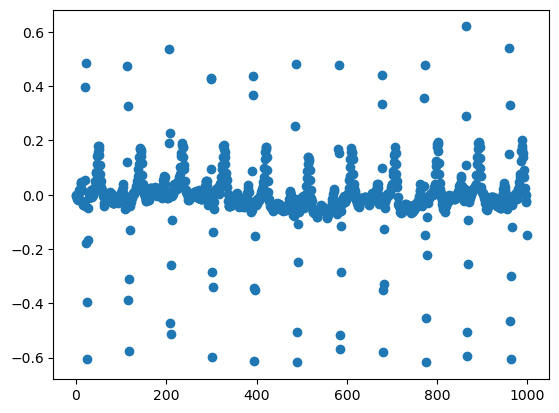

In [68]:
plt.scatter(test.index.values,test[[8]])

In [23]:
test[[0]]

,0
0,-0.119
1,-0.116
2,-0.120
3,-0.117
4,-0.103
...,...
995,0.106
996,0.090
997,0.069
998,0.086


Encoding y categories:

In [106]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.astype(str))

y_train_one_hot = to_categorical(y_train_encoded, num_classes=26)

In [202]:
print("Mapping of categories to encoded labels:")
for category, label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{category}: {label}")

Mapping of categories to encoded labels:
['CD', 'HYP', 'MI']: 0
['CD', 'MI']: 1
['CD', 'STTC', 'HYP', 'MI']: 2
['CD', 'STTC', 'MI']: 3
['CD']: 4
['HYP', 'CD']: 5
['HYP', 'MI']: 6
['HYP']: 7
['MI', 'CD']: 8
['MI', 'HYP', 'CD']: 9
['MI', 'NORM', 'HYP', 'CD']: 10
['MI', 'STTC', 'CD']: 11
['MI', 'STTC', 'HYP', 'CD']: 12
['MI']: 13
['NORM', 'CD']: 14
['NORM', 'HYP']: 15
['NORM', 'STTC', 'CD']: 16
['NORM', 'STTC']: 17
['NORM']: 18
['STTC', 'CD']: 19
['STTC', 'HYP', 'CD']: 20
['STTC', 'HYP', 'MI']: 21
['STTC', 'HYP']: 22
['STTC', 'MI']: 23
['STTC']: 24
[]: 25


## Naive model:

Majority class prediction:

In [212]:
def naive_predict(x):
    return 18

In [215]:
y_train_pred_n =[naive_predict(x) for x in range (len(X_train))]

In [207]:
accuracy_train_naive = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n).round(2)
accuracy_train_naive

0.42

Weightes of 2 major classes prediction:

In [225]:
y_train_pred_n2 =[13 if x%4 == 0 else 18 for x in range (len(X_train))]

In [226]:
accuracy_train_naive2 = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n2).round(2)
accuracy_train_naive2

0.34

Weightes of 3 major classes prediction:

In [229]:
y_train_pred_n3 =[13 if x%3 == 0 else (24 if x % 5 == 0 else 18) for x in range (len(X_train))]

In [230]:
accuracy_train_naive3 = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n3).round(2)
accuracy_train_naive3

0.28

## Neural network

Model: from ....

In [165]:

class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_model(n_classes, last_layer='sigmoid'):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    # signal = Input(shape=(4096, 12), dtype=np.float32, name='signal')
    signal = Input(shape=(1024, 12), dtype=np.float32, name='signal')   
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
    #                     kernel_initializer=kernel_initializer)([x, x])
    # x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
    #                     kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


In [166]:
ecg_model = get_model(26)

In [176]:
ecg_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d_40 (Conv1D)          (None, 1024, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization_28 (Ba  (None, 1024, 64)             256       ['conv1d_40[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 1024, 64)             0         ['batch_normalization_28

Compile:

In [172]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
ecg_model.compile(loss='binary_crossentropy', optimizer= optimizer)

Padding:

In [168]:
X_train_padded = pad_sequences(X_train, maxlen=1024, padding='post', truncating='post')
print(X_train_padded.shape)

(19601, 1024, 12)


Fitting:

In [175]:
ecg_model.fit(X_train_padded,y_train_one_hot, epochs = 10, batch_size=128)

Epoch 1/10
154/154 [==============================] - 1588s 10s/step - loss: 0.0994
Epoch 2/10
154/154 [==============================] - 1100s 7s/step - loss: 0.0947
Epoch 3/10
154/154 [==============================] - 1091s 7s/step - loss: 0.0922
Epoch 4/10
154/154 [==============================] - 1144s 7s/step - loss: 0.0890
Epoch 5/10
154/154 [==============================] - 1110s 7s/step - loss: 0.0853
Epoch 6/10
154/154 [==============================] - 1123s 7s/step - loss: 0.0807
Epoch 7/10
154/154 [==============================] - 1194s 8s/step - loss: 0.0743
Epoch 8/10
154/154 [==============================] - 1116s 7s/step - loss: 0.0669
Epoch 9/10
154/154 [==============================] - 1108s 7s/step - loss: 0.0553
Epoch 10/10
154/154 [==============================] - 1127s 7s/step - loss: 0.0444


Predict:

In [177]:
batch_size = 32  
pred_train = []

for i in range(0, len(X_train_padded), batch_size):
    batch_predictions = ecg_model.predict(X_train_padded[i:i+batch_size])
    pred_train.append(batch_predictions)

pred_train = np.concatenate(pred_train, axis=0)

1/1 [==============================] - 1s 856ms/step


In [178]:
predicted_labels = np.argmax(pred_train, axis=1)
predicted_labels

array([18, 18, 18, ..., 18, 18, 18], dtype=int64)

In [179]:
df1= pd.DataFrame(y_train_encoded, columns =['actual'])
df2= pd.DataFrame(predicted_labels, columns =['predicted'])
result_df = pd.concat([df1, df2], axis=1)
result_df.sample(10)

,actual,predicted
12862,18,18
6668,18,18
17928,24,18
8643,18,18
17383,25,25
18765,24,18
2040,4,4
4520,18,18
4685,13,13
8662,18,18


In [180]:
labels=  list(np.unique(y_train_encoded))

Evaluation:

In [181]:
accuracy_train = accuracy_score(y_true= y_train_encoded, y_pred = predicted_labels).round(2)
accuracy_train




0.78

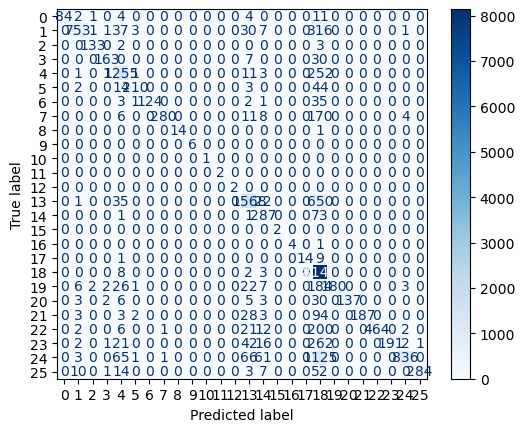

In [182]:
cm_train = confusion_matrix(y_true= y_train_encoded, y_pred = predicted_labels, labels=labels)
disp_train  = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                display_labels=labels)
disp_train.plot(cmap=plt.cm.Blues,values_format='g')


### Evaluation:

test results:

In [183]:
X_test_padded = pad_sequences(X_test, maxlen=1024, padding='post', truncating='post')

In [184]:
batch_size = 32  # Adjust this based on your available memory
pred_test = []

for i in range(0, len(X_test_padded), batch_size):
    batch_predictions = ecg_model.predict(X_test_padded[i:i+batch_size])
    pred_test.append(batch_predictions)

pred_test = np.concatenate(pred_test, axis=0)

1/1 [==============================] - 0s 473ms/step


In [185]:
y_test_encoded = label_encoder.transform(y_test.astype(str))

ValueError: y contains previously unseen labels: "['NORM', 'HYP', 'CD']"

In [ ]:
predicted_labels_test = np.argmax(pred_test, axis=1)
predicted_labels_test

In [ ]:
accuracy_test = accuracy_score(y_true= y_test_encoded, y_pred = predicted_labels_test).round(2)
accuracy_test

## Multi-label 

### Encoding 

In [249]:
mlb = MultiLabelBinarizer()
y_train_m_encoded = mlb.fit_transform(y_train)
y_train_m_encoded

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [250]:
list(mlb.classes_)

['CD', 'HYP', 'MI', 'NORM', 'STTC']

In [252]:
y_test_m_encoded = mlb.transform(y_test)
y_test_m_encoded

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

### Model: NN with multi-label encoding

In [253]:
ecg_model_ml = get_model(5)

In [254]:
ecg_model_ml.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d_50 (Conv1D)          (None, 1024, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization_35 (Ba  (None, 1024, 64)             256       ['conv1d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 1024, 64)             0         ['batch_normalization_35

In [291]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
ecg_model_ml.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [336]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Adjust patience as needed
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [337]:
my_history = ecg_model_ml.fit(X_train_padded,y_train_m_encoded, epochs = 30, batch_size=128, verbose=1,
                              validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.8476

C:\Users\Tal-Shachar\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 1057s 8s/step - loss: 0.0380 - accuracy: 0.8476 - val_loss: 0.0474 - val_accuracy: 0.7761
Epoch 2/30
138/138 [==============================] - 1079s 8s/step - loss: 0.0340 - accuracy: 0.8498 - val_loss: 0.0406 - val_accuracy: 0.8389
Epoch 3/30
138/138 [==============================] - 1079s 8s/step - loss: 0.0334 - accuracy: 0.8472 - val_loss: 0.1009 - val_accuracy: 0.8287
Epoch 4/30
138/138 [==============================] - 1074s 8s/step - loss: 0.0337 - accuracy: 0.8519 - val_loss: 0.0599 - val_accuracy: 0.7925
Epoch 5/30
138/138 [==============================] - 1074s 8s/step - loss: 0.0317 - accuracy: 0.8474 - val_loss: 0.0506 - val_accuracy: 0.8057
Epoch 6/30
138/138 [==============================] - 1064s 8s/step - loss: 0.0336 - accuracy: 0.8503 - val_loss: 0.1045 - val_accuracy: 0.8195
Epoch 7/30
138/138 [==============================] - 1077s 8s/step - loss: 0.0321 - accuracy: 0.8497 - val_loss: 0.0612 - val_accuracy: 0.8210


In [324]:
ecg_model_ml.save("multi-label-nn.keras")

INFO:tensorflow:Assets written to: multi-label-nn\assets


INFO:tensorflow:Assets written to: multi-label-nn\assets


In [422]:
epochs = 7 
batch_size=128

model_name = f'ecg_model_epoch-{epochs}_bs-{batch_size}_lr-{learning_rate}'
ecg_model_ml.save(f'{model_name}.keras')

<Axes: >

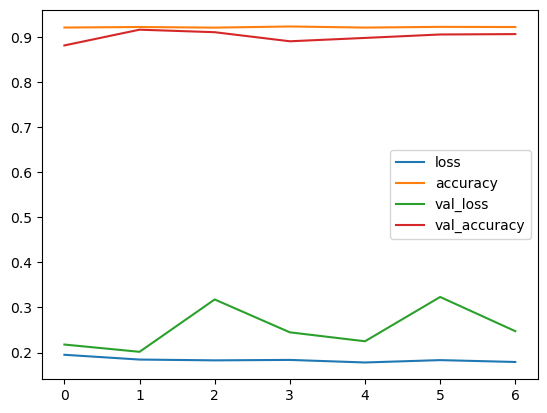

In [338]:
(pd.DataFrame(my_history.history)**0.5).plot()

### Prediction- train

In [339]:
batch_size = 32  
pred_train = []

for i in range(0, len(X_train_padded), batch_size):
    batch_predictions = ecg_model_ml.predict(X_train_padded[i:i+batch_size])
    pred_train.append(batch_predictions)

pred_train = np.concatenate(pred_train, axis=0)

1/1 [==============================] - 0s 343ms/step


In [414]:
pred_train

array([[1.92938423e-05, 2.27618742e-08, 2.64925556e-03, 9.99999046e-01,
        1.19893127e-08],
       [6.68231496e-06, 7.27139593e-07, 8.72187968e-07, 9.99927819e-01,
        4.38134492e-07],
       [4.15787287e-03, 1.51985012e-06, 1.57294213e-03, 9.98265982e-01,
        2.48662182e-05],
       ...,
       [2.77046376e-04, 5.63527065e-05, 4.13847622e-03, 1.56880766e-01,
        1.47022739e-01],
       [1.84038697e-07, 1.47701105e-11, 2.14877364e-05, 9.99999285e-01,
        1.17933086e-08],
       [1.04893059e-06, 3.52948916e-07, 2.05776514e-03, 9.99965072e-01,
        3.32451009e-08]], dtype=float32)

In [340]:
thr = 0.5


In [341]:
encoded_pred_train =(pred_train>thr).astype(int)

In [342]:
encoded_pred_train

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [407]:
accuracy_train = accuracy_score(y_true= y_train_m_encoded, y_pred = encoded_pred_train).round(2)
accuracy_train

0.97

In [359]:
y_train_m_encoded[y_train_m_encoded.sum(axis=1)>1]

array([[0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0]])

### Confusion matrix:

In [348]:
def multi_label_confusion_matrix(y_true, y_pred, n_classes):
    """
    Create a 6x6 confusion matrix for multi-label classification.

    :param y_true: True labels (2D array: samples x labels)
    :param y_pred: Predicted labels (2D array: samples x labels)
    :param n_classes: Number of classes
    """
    # Initialize the confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Populate the confusion matrix
    for i in range(n_classes):
        for j in range(n_classes):
            if i == j:
                # Diagonal: True Positives for class i
                cm[i, j] = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 1))
            else:
                # Off-diagonal: Count how many times class i was predicted when it was actually class j
                cm[i, j] = np.sum((y_true[:, j] == 1) & (y_pred[:, i] == 1))

    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix.

    :param cm: Confusion matrix
    :param class_names: Names of the classes
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multi-Label Confusion Matrix')
    plt.show()

# Example usage
# y_true = ... # Your true labels
# y_pred = ... # Your predicted labels
# n_classes = 6
# class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']
# cm = multi_label_confusion_matrix(y_true, y_pred, n_classes)
# plot_confusion_matrix(cm, class_names)


In [350]:
cm= multi_label_confusion_matrix(y_true= y_train_m_encoded, y_pred = encoded_pred_train, n_classes = len(mlb.classes_))

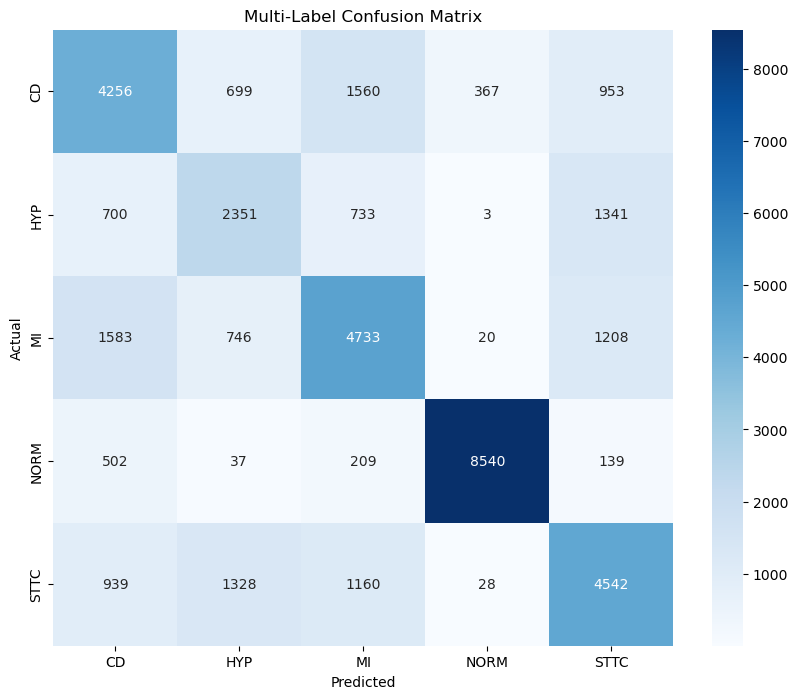

In [351]:
plot_confusion_matrix(cm, class_names= mlb.classes_)

### Prediction- test:

In [344]:
batch_size = 32  
pred_test = []

for i in range(0, len(X_test_padded), batch_size):
    batch_predictions = ecg_model_ml.predict(X_test_padded[i:i+batch_size])
    pred_test.append(batch_predictions)

pred_test = np.concatenate(pred_test, axis=0)

1/1 [==============================] - 0s 388ms/step


In [345]:
pred_test

array([[7.44322606e-04, 1.28848342e-07, 2.02533171e-01, 4.68404684e-03,
        4.44840589e-05],
       [6.55617611e-03, 5.77888182e-10, 5.00104809e-03, 9.99392748e-01,
        3.46757020e-06],
       [6.01124157e-07, 5.25755400e-04, 7.45302081e-01, 6.57603800e-01,
        3.32060446e-09],
       ...,
       [2.18298243e-04, 5.86094260e-01, 7.88383603e-01, 3.38262157e-06,
        9.67987597e-01],
       [9.98456836e-01, 1.22218148e-06, 5.90332091e-01, 4.62290245e-07,
        1.18285883e-02],
       [5.43695807e-01, 7.88771803e-09, 6.52077645e-02, 8.27560127e-02,
        1.08656255e-04]], dtype=float32)

In [346]:
encoded_pred_test = (pred_test>thr).astype(int)

In [347]:
accuracy_test = accuracy_score(y_true= y_test_m_encoded, y_pred = encoded_pred_test).round(2)
accuracy_test

0.34

In [365]:
f= y_test_m_encoded[y_test_m_encoded.sum(axis=1)==1]

In [366]:
cm2= multi_label_confusion_matrix(y_true= y_test_m_encoded[f], y_pred = encoded_pred_test[f], n_classes = len(mlb.classes_))

In [371]:
mlb.classes_

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

In [374]:
y_test.value_counts()

diagnostic_superclass
[NORM]                 912
[MI]                   256
[STTC]                 242
[CD]                   184
[CD, MI]               129
[STTC, HYP]             73
[STTC, MI]              61
[HYP]                   56
[NORM, CD]              45
[STTC, HYP, MI]         41
[]                      40
[STTC, CD]              38
[HYP, CD]               27
[STTC, HYP, CD]         25
[CD, STTC, MI]          20
[HYP, MI]               17
[CD, STTC, HYP, MI]     16
[CD, HYP, MI]            5
[MI, CD]                 4
[NORM, STTC]             4
[NORM, HYP, CD]          2
[MI, STTC, CD]           1
Name: count, dtype: int64

In [373]:
((y_test_m_encoded == [1,0,0,0,0]).sum(axis=1) == 5).sum()

184

In [375]:
((encoded_pred_test == [1,0,0,0,0]).sum(axis=1) == 5).sum()

133

In [397]:
f= y_test_m_encoded.sum(axis=1)>1
f

array([False, False, False, ..., False, False, False])

In [398]:
y_test_multi_class = np.argmax(y_test_m_encoded, axis=1)[f]
y_test_multi_class

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2, 0, 2,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 2,
       1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0,
       0, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 3,
       0, 0, 0, 1, 0, 2, 1, 0, 1, 2, 3, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 1,
       2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0, 1,
       0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_multi_class = np.argmax(y_test_m_encoded, axis=1)[f]
y_test_multi_class

In [399]:
y_test_multi_class_pred = np.argmax(encoded_pred_test, axis=1)[f]
y_test_multi_class_pred

array([0, 3, 2, 1, 1, 1, 4, 1, 3, 0, 1, 3, 1, 2, 2, 0, 2, 0, 3, 0, 3, 3,
       3, 3, 0, 4, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 3, 2, 3, 0,
       0, 0, 0, 3, 2, 1, 1, 0, 2, 2, 4, 2, 3, 0, 3, 0, 2, 3, 1, 3, 1, 4,
       3, 2, 0, 3, 0, 0, 2, 4, 0, 3, 2, 1, 0, 3, 0, 0, 4, 2, 3, 3, 0, 3,
       0, 3, 3, 4, 0, 3, 2, 0, 3, 0, 1, 1, 3, 1, 1, 3, 0, 3, 0, 1, 2, 3,
       4, 0, 3, 2, 0, 1, 0, 0, 1, 2, 3, 2, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 2, 2, 1, 0, 0, 3, 0, 1, 0, 4, 3, 3, 0, 0, 3, 2,
       2, 0, 1, 0, 2, 0, 3, 0, 1, 4, 3, 2, 3, 0, 1, 1, 2, 3, 3, 4, 1, 4,
       3, 3, 2, 0, 3, 0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 1, 3, 0, 0, 2, 2, 0, 2, 0, 0, 0,
       0, 3, 0, 3, 3, 1, 0, 0, 0, 3, 0, 0, 3, 2, 3, 0, 3, 3, 2, 3, 2, 2,
       1, 0, 2, 2, 1, 0, 0, 0, 3, 3, 3, 1, 3, 3, 0, 3, 3, 0, 2, 3, 2, 0,
       3, 3, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 3, 3, 0, 0, 0, 2, 1,
       3, 2, 2, 0, 2, 3, 0, 2, 3, 0, 3, 3, 0, 0, 0,

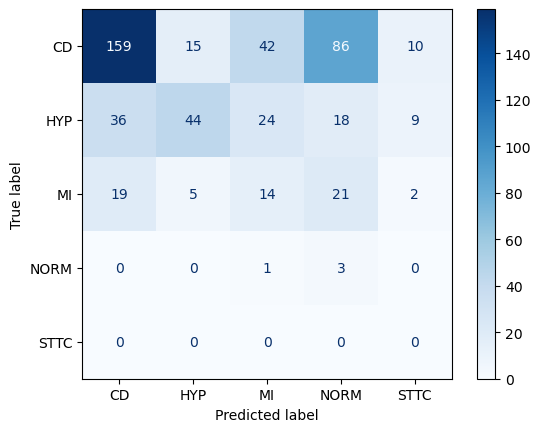

In [406]:
cm_test = confusion_matrix(y_true= y_test_multi_class, y_pred = y_test_multi_class_pred)
disp_test  = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= mlb.classes_)
disp_test.plot(cmap=plt.cm.Blues,values_format='g')

In [384]:
encoded_pred_test

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       ...,
       [0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

In [370]:
y_test_m_encoded[f]

array([[[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       ...,

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]])

In [ ]:
y_test_m_encoded[y_test_m_encoded.sum(axis=1)==1]

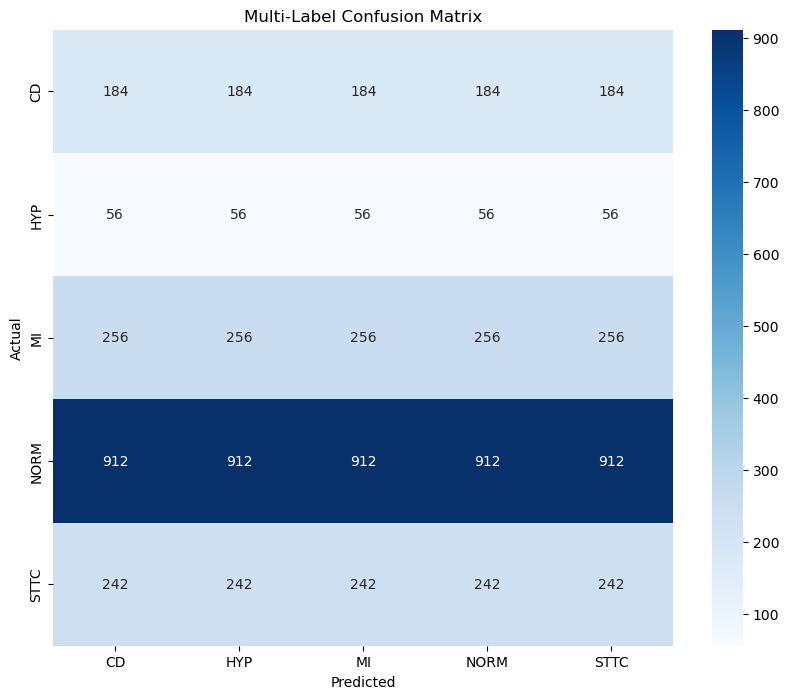

In [367]:
plot_confusion_matrix(cm2, class_names= mlb.classes_)

In [354]:
cm2.sum()

3149

In [355]:
len(y_test)

2198

In [429]:
len(y_test_m_encoded.sum(axis=1)==1)

2198

In [430]:
np.argmax(y_test_m_encoded, axis=1)

array([3, 3, 3, ..., 3, 0, 2], dtype=int64)

Input Array Size: 1650
Confusion Matirx Summary: 1650

Actual Frequecies: {0: 184, 1: 56, 2: 256, 3: 912, 4: 242}
Confusion Matirx rows sum: [184, 56, 256, 912, 242]
Confusion Matirx cols sum: [455, 34, 233, 865, 63]


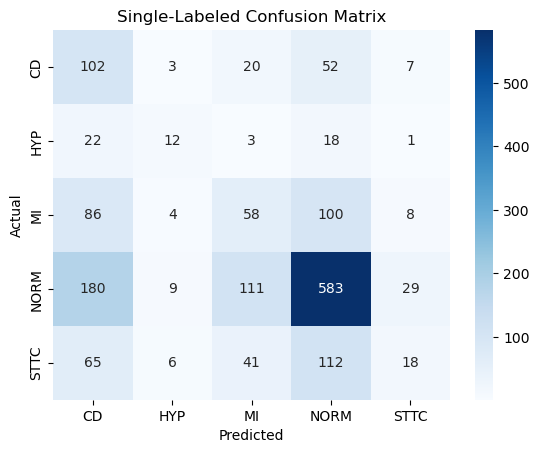

In [425]:
from collections import Counter

def plot_confusion_matrix(cm, class_names, title='Multi-Label Confusion Matrix'):
    """
    Plot the confusion matrix.

    :param cm: Confusion matrix
    :param class_names: Names of the classes
    """
    plt.figure()#(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def single_label_examination(y_true, y_pred):
    f = y_true.sum(axis=1)==1
    y_true_multi_class = np.argmax(y_true, axis=1)[f]
    y_pred_multi_class = np.argmax(y_pred, axis=1)[f]

    cm_singleLabel = confusion_matrix(y_true=y_true_multi_class, y_pred=y_pred_multi_class)
    # Count Validation
    print(f'Input Array Size: {len(y_true_multi_class)}')
    print(f'Confusion Matirx Summary: {cm_singleLabel.sum()}\n')
    
    # Rows Validation
    frequency = Counter(y_true_multi_class)
    frequency = {k: frequency[k] for k in sorted(frequency)}
    print(f'Actual Frequecies: {frequency}')
    print(f'Confusion Matirx rows sum: {list(cm_singleLabel.sum(axis=1))}')
    
    # Confusion
    print(f'Confusion Matirx cols sum: {list(cm_singleLabel.sum(axis=0))}')

    plot_confusion_matrix(cm_singleLabel, class_names=mlb.classes_, title='Single-Labeled Confusion Matrix')

#Example Usage:
#single_label_examination(y_true=y_train_m_encoded, y_pred=y_train_pred_multi_class)
single_label_examination(y_true=y_test_m_encoded, y_pred=encoded_pred_test)


## Model with 2 labels: filter the data

### just MI & STTC categories:


In [465]:
new_y = [' '.join(map(str, x)) for x in y_train.values]
new_y

['NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'MI',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 '',
 '',
 'NORM',
 '',
 'NORM',
 'STTC',
 '',
 'NORM',
 'NORM',
 'STTC',
 'NORM',
 'STTC',
 'NORM',
 'HYP',
 'NORM',
 'CD',
 'NORM',
 '',
 'NORM',
 'NORM',
 'NORM',
 'STTC MI',
 'CD',
 'NORM',
 'NORM',
 'NORM',
 'HYP CD',
 'NORM',
 'NORM',
 'STTC',
 'CD',
 'CD MI',
 'NORM',
 'CD',
 'NORM',
 'STTC',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'CD MI',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'STTC CD',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'HYP',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'STTC CD',
 'CD MI',
 'NORM',
 'NORM',
 'HYP MI',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'NORM',
 'STTC',
 'NORM',
 'MI',
 'STTC',
 'STTC',
 'STTC',
 

In [469]:
y_train_n = pd.Series(new_y, index = y_train.index)
y_train_n.loc[20:40]

ecg_id
20           
21       NORM
22       STTC
23           
24       NORM
25       NORM
26       STTC
27       NORM
28       STTC
29       NORM
30        HYP
31       NORM
32         CD
33       NORM
34           
35       NORM
36       NORM
37       NORM
39    STTC MI
dtype: object

In [473]:
y_train_n[(y_train_n == 'STTC') | (y_train_n == 'MI')]

ecg_id
8          MI
22       STTC
26       STTC
28       STTC
48       STTC
         ... 
21816    STTC
21820      MI
21824      MI
21833    STTC
21835    STTC
Length: 4434, dtype: object

In [497]:
filter_ind = y_train_n[(y_train_n == 'STTC') | (y_train_n == 'MI')].index
filter_ind

Index([    8,    22,    26,    28,    48,    54,   127,   131,   133,   134,
       ...
       21794, 21798, 21799, 21806, 21811, 21816, 21820, 21824, 21833, 21835],
      dtype='int64', name='ecg_id', length=4434)

In [554]:
y_train_filt = y_train_n.loc[filter_ind].values
y_train_filt = np.where(y_train_filt == 'MI', 0, 1)

In [559]:
y_t = np.column_stack((y_train_filt, abs(1 - y_train_filt)))

In [509]:
X_train_padded_df = pd.DataFrame({'id': y_train.index, 'data': [arr for arr in X_train_padded]} )
X_train_padded_df = X_train_padded_df.set_index('id')
X_train_padded_df.head()

,data
id,
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ..."


In [548]:
filt_X_train = X_train_padded_df.data.loc[filter_ind]
filt_X_train = np.stack(filt_X_train.values)

### Function

In [620]:
def filter_data_by_labels(X,y, lables):
    
    new_y = pd.Series([' '.join(map(str, x)) for x in y.values], index = y.index)
    filter_ind = new_y[(new_y == lables[0] ) | (new_y == labels[1])].index
    y_filt = new_y.loc[filter_ind].values
    y_filt = np.where(y_filt == 'MI', 0, 1)
    y_filt = np.column_stack((y_filt, abs(1 - y_filt)))
    X_df = pd.DataFrame({'id': y.index, 'data': [arr for arr in X]} )
    X_df = X_df.set_index('id')
    X_filt = X_df.data.loc[filter_ind]
    X_filt = np.stack(X_filt.values)
    return X_filt, y_filt


In [640]:
filt_X_train, filt_y_train = filter_data_by_labels(X_train_padded, y_train, ['STTC','MI'])

In [622]:
filt_X_test, filt_y_test = filter_data_by_labels(X_test_padded, y_test, ['STTC','MI'])


### new model- STTC & MI categories 

In [533]:
ecg_model_IIL = get_model(2)

In [575]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
ecg_model_IIL.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [576]:
my_history_IIL = ecg_model_IIL.fit(filt_X_train,y_t, epochs = 30, batch_size=128, 
                                   verbose=1,validation_split=0.1)

Epoch 1/30
32/32 [==============================] - 254s 8s/step - loss: 0.7075 - accuracy: 0.6048 - val_loss: 0.6536 - val_accuracy: 0.6171
Epoch 2/30
32/32 [==============================] - 274s 9s/step - loss: 0.6633 - accuracy: 0.6353 - val_loss: 0.6384 - val_accuracy: 0.6284
Epoch 3/30
32/32 [==============================] - 268s 8s/step - loss: 0.6481 - accuracy: 0.6454 - val_loss: 0.6572 - val_accuracy: 0.6059
Epoch 4/30
32/32 [==============================] - 246s 8s/step - loss: 0.6210 - accuracy: 0.6729 - val_loss: 0.6313 - val_accuracy: 0.6667
Epoch 5/30
32/32 [==============================] - 250s 8s/step - loss: 0.6165 - accuracy: 0.6820 - val_loss: 0.6500 - val_accuracy: 0.6599
Epoch 6/30
32/32 [==============================] - 246s 8s/step - loss: 0.5994 - accuracy: 0.6995 - val_loss: 0.6637 - val_accuracy: 0.6261
Epoch 7/30
32/32 [==============================] - 247s 8s/step - loss: 0.5343 - accuracy: 0.7353 - val_loss: 0.6416 - val_accuracy: 0.6509
Epoch 8/30
32

In [638]:
epochs = 30 
batch_size=128

model_name = f'11-01-24_STTC_MI_model_epoch-{epochs}_bs-{batch_size}_lr-{learning_rate}'
ecg_model_IIL.save(f'{model_name}.keras')

In [577]:
y_train_pred = ecg_model_IIL.predict(filt_X_train)

139/139 [==============================] - 77s 541ms/step


In [581]:
encoded_pred_train =(y_train_pred>thr).astype(int)
accuracy_train = accuracy_score(y_true= y_t, y_pred = encoded_pred_train).round(2)
accuracy_train

0.93

In [623]:
y_test_pred = ecg_model_IIL.predict(filt_X_test)

16/16 [==============================] - 7s 395ms/step


In [626]:
encoded_pred_test =(y_test_pred>thr).astype(int)
accuracy_test = accuracy_score(y_true= filt_y_test, y_pred = encoded_pred_test).round(2)
accuracy_test

0.55

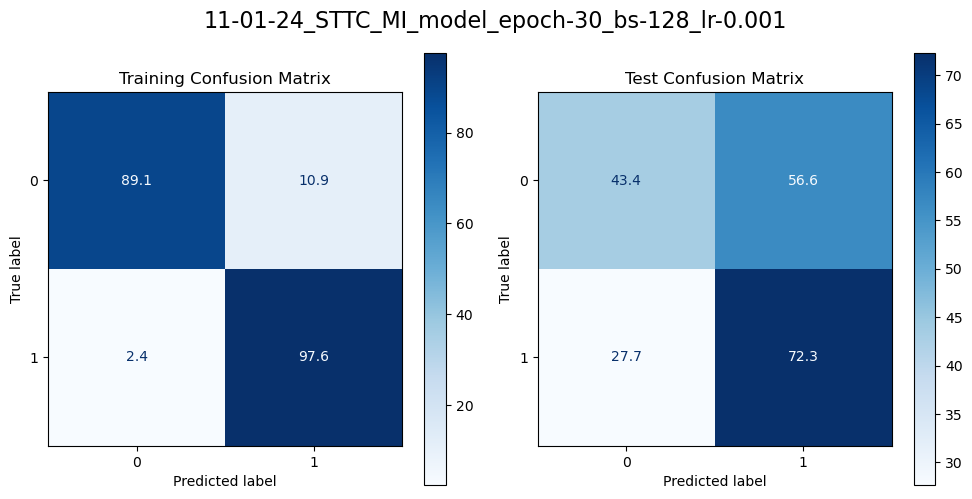

In [650]:
cm_train = confusion_matrix(y_true= filt_y_train[:,0], y_pred = encoded_pred_train[:,0], labels=[0,1], normalize='true') * 100
disp_train  = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                display_labels=[0,1])
cm_test = confusion_matrix(y_true= filt_y_test[:,0], y_pred = encoded_pred_test[:,0], labels=[0,1], normalize='true') * 100
disp_test  = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                display_labels=[0,1])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
disp_train.plot(ax=axes[0],cmap=plt.cm.Blues,values_format='.1f')
axes[0].set_title('Training Confusion Matrix')
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues,values_format='.1f')
axes[1].set_title('Test Confusion Matrix')
plt.suptitle(model_name, fontsize=16)
plt.tight_layout()
plt.show()



In [661]:
print(f"MI in train: {len(filt_y_train[filt_y_train[:,0]==0])}\nSTTC in train: {len(filt_y_train[filt_y_train[:,0]==1])}")
print(f"MI in test: {len(filt_y_test[filt_y_test[:,0]==0])}\nSTTC in test: {len(filt_y_test[filt_y_test[:,0]==1])}")
print(f"Accuracy train: {accuracy_train}\nAccuracy test: {accuracy_test}")

MI in train: 2276
STTC in train: 2158
MI in test: 256
STTC in test: 242
Accuracy train: 0.93
Accuracy test: 0.55


In [639]:
ecg_model_IL = get_model(1)

### Raz function:

In [565]:
def filter_labels_and_data(X_data, y_data, labels_to_keep):
    """
    Filters the y_data to only include specified labels and
    corresponding X_data.

    :param X_data: Numpy array with the first dimension matching y_data length
    :param y_data: List of lists of labels
    :param labels_to_keep: List of labels to keep
    :return: Tuple of filtered X_data and y_data
    """
    # Filter out the labels not in labels_to_keep from each sublist in y_data
    y_filtered = [[label for label in sublist if label in labels_to_keep] for sublist in y_data]
    
    # Filter out the corresponding X_data based on non-empty filtered y_data
    indices_to_keep = [i for i, sublist in enumerate(y_filtered) if sublist]
    X_filtered = X_data[indices_to_keep]
    y_filtered = [y_filtered[i] for i in indices_to_keep]
    
    return X_filtered, y_filtered

# Example usage
import numpy as np

# Assuming X_data is a numpy array with the same first dimension as y
y = [['NORM'], ['MI'], [], ['STTC'], ['MI', 'CD'], ['NORM'], ['NORM'], [], ['HYP', 'STTC']]
labels = ['STTC', 'MI']

# Generate X_data
X_data = np.ones([len(y),3,3])
for i in range(len(y)):
    X_data[i] = X_data[i] * i

X_out, y_out = filter_labels_and_data(X_train_padded, y_train.values, labels)
X_out, y_out


(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [570]:
type(X_out)

numpy.ndarray

## Loading model

In [ ]:
loaded_model = load_model(f'{model_name}.keras')

In [ ]:
loaded_model.predict(X_train_padded[0:10])

## Pipelines

In [334]:
def padding(X):
    return pad_sequences(X, maxlen=1024, padding='post', truncating='post')

signals_pipeline = Pipeline([
    ('pad_sequences', FunctionTransformer(func= padding))
])
signals_pipeline

Pipeline(steps=[('pad_sequences',
                 FunctionTransformer(func=<function padding at 0x0000011FD114A8E0>))])

In [335]:
padd_sig = signals_pipeline.transform(X_train)
padd_sig.shape

(19601, 1024, 12)

In [ ]:
ecg_model_ml